In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [7]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [8]:
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [9]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [10]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [11]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [12]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [13]:
def build_1d_cnn_custom_conv_3_VGG_DO_075_DO(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same', 
                      activation='relu', input_shape=input_shape)) 
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same', 
                  activation='relu')) 
#     model.add(BatchNormalization())
#     model.add(MaxPooling1D(pool_size=3, strides=3))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same', 
                          activation='relu'))
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same', 
                          activation='relu'))         
#         model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.75))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [14]:
for i in range(1, 10):
    model = build_1d_cnn_custom_conv_3_VGG_DO_075_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 64)         12352     
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 16,396,624
Trainable params: 16,396,624
Non-trainable params: 0
_________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_30 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 5333, 64)          12352     
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 5333, 64)          12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 5333, 64)          12352     
_________________________________________________________________
conv1d_77 (Conv1D)           (None, 5333, 64)          12352     
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7484 - acc: 0.0790
Epoch 00001: val_loss improved from inf to 2.72719, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_SGD_8_conv_checkpoint/001-2.7272.hdf5
36805/36805 [==============================] - 93s 3ms/sample - loss: 2.7484 - acc: 0.0790 - val_loss: 2.7272 - val_acc: 0.0820
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7294 - acc: 0.0795
Epoch 00002: val_loss improved from 2.72719 to 2.72077, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_SGD_8_conv_checkpoint/002-2.7208.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 2.7294 - acc: 0.0795 - val_loss: 2.7208 - val_acc: 0.0820
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7258 - acc: 0.0785
Epoch 00003: val_loss improved from 2.7

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7103 - acc: 0.4340
Epoch 00024: val_loss improved from 1.89381 to 1.51490, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_SGD_8_conv_checkpoint/024-1.5149.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 1.7103 - acc: 0.4339 - val_loss: 1.5149 - val_acc: 0.4836
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5426 - acc: 0.4881
Epoch 00025: val_loss improved from 1.51490 to 1.33844, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_SGD_8_conv_checkpoint/025-1.3384.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 1.5426 - acc: 0.4881 - val_loss: 1.3384 - val_acc: 0.5625
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4067 - acc: 0.5327
Epoch 00026: val_loss improved from 1.33844 to 1.27654, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_SGD_8

Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3167 - acc: 0.8992
Epoch 00049: val_loss improved from 0.21763 to 0.17533, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_SGD_8_conv_checkpoint/049-0.1753.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.3167 - acc: 0.8992 - val_loss: 0.1753 - val_acc: 0.9457
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2962 - acc: 0.9076
Epoch 00050: val_loss did not improve from 0.17533
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.2962 - acc: 0.9076 - val_loss: 0.1821 - val_acc: 0.9436
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2833 - acc: 0.9112
Epoch 00051: val_loss did not improve from 0.17533
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.2833 - acc: 0.9112 - val_loss: 0.1763 - val_acc: 0.9469
Epoch 52/500
36800/36805 [============================>.] - E

Epoch 76/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1454 - acc: 0.9547
Epoch 00076: val_loss did not improve from 0.11124
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1454 - acc: 0.9547 - val_loss: 0.1130 - val_acc: 0.9644
Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1384 - acc: 0.9554
Epoch 00077: val_loss did not improve from 0.11124
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1383 - acc: 0.9554 - val_loss: 0.1264 - val_acc: 0.9634
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1371 - acc: 0.9556
Epoch 00078: val_loss did not improve from 0.11124
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1371 - acc: 0.9556 - val_loss: 0.1357 - val_acc: 0.9611
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1362 - acc: 0.9566
Epoch 00079: val_loss did not improve from 0.11124
36805/36805 [===========

Epoch 105/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0886 - acc: 0.9701
Epoch 00105: val_loss did not improve from 0.09672
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0886 - acc: 0.9701 - val_loss: 0.1173 - val_acc: 0.9686
Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0887 - acc: 0.9710
Epoch 00106: val_loss did not improve from 0.09672
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0887 - acc: 0.9710 - val_loss: 0.1038 - val_acc: 0.9697
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0814 - acc: 0.9729
Epoch 00107: val_loss did not improve from 0.09672
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0814 - acc: 0.9729 - val_loss: 0.1079 - val_acc: 0.9695
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0836 - acc: 0.9727
Epoch 00108: val_loss did not improve from 0.09672
36805/36805 [=======

Epoch 135/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0561 - acc: 0.9808
Epoch 00135: val_loss did not improve from 0.09672
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0561 - acc: 0.9808 - val_loss: 0.1226 - val_acc: 0.9723
Epoch 136/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0616 - acc: 0.9806
Epoch 00136: val_loss did not improve from 0.09672
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0616 - acc: 0.9806 - val_loss: 0.1091 - val_acc: 0.9723
Epoch 137/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0555 - acc: 0.9814
Epoch 00137: val_loss did not improve from 0.09672
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0555 - acc: 0.9814 - val_loss: 0.1319 - val_acc: 0.9713
Epoch 138/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0556 - acc: 0.9812
Epoch 00138: val_loss did not improve from 0.09672
36805/36805 [=======

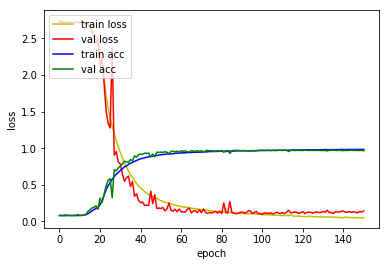

4815/4815 [==============================] - 5s 978us/sample - loss: 0.1351 - acc: 0.9603
Loss: 0.1350821490982704 Accuracy: 0.9603323

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7466 - acc: 0.0786
Epoch 00001: val_loss improved from inf to 2.72701, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_SGD_9_conv_checkpoint/001-2.7270.hdf5
36805/36805 [==============================] - 93s 3ms/sample - loss: 2.7466 - acc: 0.0786 - val_loss: 2.7270 - val_acc: 0.0785
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7282 - acc: 0.0785
Epoch 00002: val_loss improved from 2.72701 to 2.72011, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_SGD_9_conv_checkpoint/002-2.7201.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 2.7282 - acc: 0.0785 - val_loss: 2.7201 - val_acc: 0.0818
Epoch 3/500
36800/36805 [======================

36800/36805 [============================>.] - ETA: 0s - loss: 1.5882 - acc: 0.4775
Epoch 00022: val_loss improved from 1.84941 to 1.33196, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_SGD_9_conv_checkpoint/022-1.3320.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 1.5881 - acc: 0.4775 - val_loss: 1.3320 - val_acc: 0.5581
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3383 - acc: 0.5603
Epoch 00023: val_loss improved from 1.33196 to 1.10612, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_SGD_9_conv_checkpoint/023-1.1061.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 1.3382 - acc: 0.5603 - val_loss: 1.1061 - val_acc: 0.6508
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1649 - acc: 0.6192
Epoch 00024: val_loss improved from 1.10612 to 0.93306, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_SGD_9_conv_checkpo

Epoch 45/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2504 - acc: 0.9215
Epoch 00045: val_loss improved from 0.21911 to 0.20724, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_SGD_9_conv_checkpoint/045-0.2072.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.2504 - acc: 0.9215 - val_loss: 0.2072 - val_acc: 0.9378
Epoch 46/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2282 - acc: 0.9286
Epoch 00046: val_loss did not improve from 0.20724
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.2282 - acc: 0.9285 - val_loss: 0.3028 - val_acc: 0.9115
Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2216 - acc: 0.9313
Epoch 00047: val_loss improved from 0.20724 to 0.17735, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_SGD_9_conv_checkpoint/047-0.1773.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.2217 -

36800/36805 [============================>.] - ETA: 0s - loss: 0.0836 - acc: 0.9731
Epoch 00072: val_loss did not improve from 0.14641
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0836 - acc: 0.9731 - val_loss: 0.1542 - val_acc: 0.9609
Epoch 73/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0821 - acc: 0.9724
Epoch 00073: val_loss did not improve from 0.14641
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0821 - acc: 0.9724 - val_loss: 0.1799 - val_acc: 0.9520
Epoch 74/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0794 - acc: 0.9736
Epoch 00074: val_loss did not improve from 0.14641
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0794 - acc: 0.9736 - val_loss: 0.1584 - val_acc: 0.9595
Epoch 75/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0784 - acc: 0.9752
Epoch 00075: val_loss did not improve from 0.14641
36805/36805 [========================

Epoch 102/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0390 - acc: 0.9869
Epoch 00102: val_loss did not improve from 0.14641
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0390 - acc: 0.9869 - val_loss: 0.2285 - val_acc: 0.9581
Epoch 103/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0410 - acc: 0.9864
Epoch 00103: val_loss did not improve from 0.14641
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0410 - acc: 0.9863 - val_loss: 0.1932 - val_acc: 0.9583
Epoch 104/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0473 - acc: 0.9845
Epoch 00104: val_loss did not improve from 0.14641
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0473 - acc: 0.9845 - val_loss: 0.2210 - val_acc: 0.9597
Epoch 105/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0384 - acc: 0.9875
Epoch 00105: val_loss did not improve from 0.14641
36805/36805 [=======

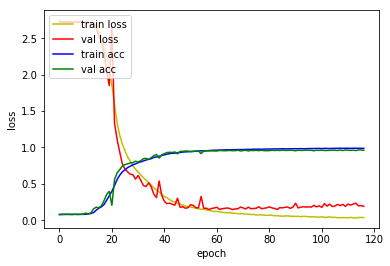

4815/4815 [==============================] - 5s 959us/sample - loss: 0.2045 - acc: 0.9421
Loss: 0.2044540225886977 Accuracy: 0.94205606



In [15]:
base = '1D_CNN_custom_conv_3_VGG_DO_075_DO_SGD'

for i in range(8, 10):
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_conv_3_VGG_DO_075_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', 
                  optimizer=SGD(lr=0.001, momentum=0.9, decay=1e-6, nesterov=True),
                  metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)
    
    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [16]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_DO_075_DO_SGD'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_DO_075_DO_SGD_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_92 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_93 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_94 (Conv1D)           (None, 5333, 64)          12352     
_________________________________________________________________
conv1d_95 (Conv1D)     

4815/4815 [==============================] - 5s 965us/sample - loss: 2.7130 - acc: 0.0781
Loss: 2.7129934609493365 Accuracy: 0.078089304

1D_CNN_custom_conv_3_VGG_DO_075_DO_SGD_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_126 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
conv1d_127 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_128 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_129 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_50 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_130 (Conv1D

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2045 - acc: 0.9421
Loss: 0.2044540225886977 Accuracy: 0.94205606


In [17]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_conv_3_VGG_DO_075_DO'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_DO_075_DO_SGD_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_92 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_93 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_94 (Conv1D)           (None, 5333, 64)          12352     
_________________________________________________________________
conv1d_95 (Conv1D)     

4815/4815 [==============================] - 5s 1ms/sample - loss: 2.7131 - acc: 0.0800
Loss: 2.713131129382679 Accuracy: 0.07995846

1D_CNN_custom_conv_3_VGG_DO_075_DO_SGD_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_126 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
conv1d_127 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_128 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_129 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_50 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_130 (Conv1D)   

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2661 - acc: 0.9510
Loss: 0.2661246947166974 Accuracy: 0.9509865
